<a href="https://colab.research.google.com/github/praveentn/MidcurveNN/blob/master/sgd_callback_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SGD Callback

Source: https://www.kaggle.com/ahsongchen/stochastic-gradient-descent-with-restarts-test


In [1]:
# mount google drive & set working directory
# requires auth (click on url & copy token into text box when prompted)
from google.colab import drive
drive.mount("/content/gdrive")

import os
print(os.getcwd())

os.chdir('/content/gdrive/My Drive/Colab Notebooks/MidcurveNN')
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
/content/gdrive/My Drive/Colab Notebooks/MidcurveNN


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import time
from IPython.display import clear_output

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers, optimizers
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam,RMSprop,SGD
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,AveragePooling2D,UpSampling2D
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from random import shuffle
import PIL
import json
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TKAgg')
%matplotlib inline

Using TensorFlow backend.


In [3]:
# working directory
wdir = os.getcwd()
wdir

'/content/gdrive/My Drive/Colab Notebooks/MidcurveNN'

In [4]:
# _URL = 'https://drive.google.com/uc?export=download&id=16rqDFLO__WySSQGlAht0FEj2uJZg4M9M'

# path_to_zip = tf.keras.utils.get_file('input.zip',
#                                       origin=_URL,
#                                       extract=True)

# input_data_folder = os.path.join(os.path.dirname(path_to_zip), 'input')
input_data_folder = wdir + "/data/input"
input_data_folder = wdir + "/data/9shapes"
print("input data dir: ", input_data_folder)

input data dir:  /content/gdrive/My Drive/Colab Notebooks/MidcurveNN/data/9shapes


In [5]:
import glob

image_paths = glob.glob(input_data_folder + '/**/*.png', recursive=True)
images = [os.path.basename(img_path) for img_path in image_paths]

print(len(images))

#images = os.listdir(input_data_folder)
images[99]

2016


'Iuvw_Midcurve_mirrored_1_rotated_30.png'

In [0]:
# image dimension
imdim = 101

In [0]:
def read_input_image_pairs(datafolder=input_data_folder):
    profile_pngs = []
    midcurve_pngs = []
    for file in os.listdir(datafolder):
        fullpath = os.path.join(datafolder, file)
        if os.path.isdir(fullpath):
            continue
        if file.endswith(".png"):
            if file.find("Profile") != -1:
                profile_pngs.append(fullpath)
            if file.find("Midcurve") != -1:
                midcurve_pngs.append(fullpath)
    profile_pngs = sorted(profile_pngs)
    midcurve_pngs = sorted(midcurve_pngs)
    return profile_pngs,midcurve_pngs


def get_training_data(datafolder=input_data_folder):
    profile_pngs,midcurve_pngs = read_input_image_pairs(datafolder)
    
    profile_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(imdim, imdim))) for f in profile_pngs ]
    midcurve_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(imdim, imdim))) for f in midcurve_pngs]

#     profile_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in profile_pngs_objs])
#     midcurve_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in midcurve_pngs_objs])

    profile_pngs_gray_objs = [x[:,:,3] for x in profile_pngs_objs]
    midcurve_pngs_gray_objs =[x[:,:,3] for x in midcurve_pngs_objs]
    
#     profile_pngs_gray_objs = [np.where(x>128, 0, 1) for x in profile_pngs_gray_objs]
#     midcurve_pngs_gray_objs =[np.where(x>128, 0, 1) for x in midcurve_pngs_gray_objs]
        
    # shufle them
    zipped_profiles_midcurves = [(p,m) for p,m in zip(profile_pngs_gray_objs,midcurve_pngs_gray_objs)]
    shuffle(zipped_profiles_midcurves)
    profile_pngs_gray_objs, midcurve_pngs_gray_objs = zip(*zipped_profiles_midcurves)
    
    return profile_pngs_gray_objs, midcurve_pngs_gray_objs


In [8]:
profile_pngs_objs = ()
midcurve_pngs_objs = ()
shapes = ["CapI", "InvV", "Iuvw", "Luvw", "Plus", "Sm_n", "SqLu", "Tuvw", "Vuvw", ]

for shape in shapes:
    print(shape)
    tp, tm = get_training_data(os.path.join(input_data_folder, shape))
    profile_pngs_objs += tp
    midcurve_pngs_objs += tm
    print(len(profile_pngs_objs), len(midcurve_pngs_objs))

CapI
112 112
InvV
224 224
Iuvw
336 336
Luvw
448 448
Plus
560 560
Sm_n
672 672
SqLu
784 784
Tuvw
896 896
Vuvw
1008 1008


In [0]:
def plot_results(original_imgs,computed_imgs,n=10):
    # n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(imdim, imdim),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(computed_imgs[i].reshape(imdim, imdim),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

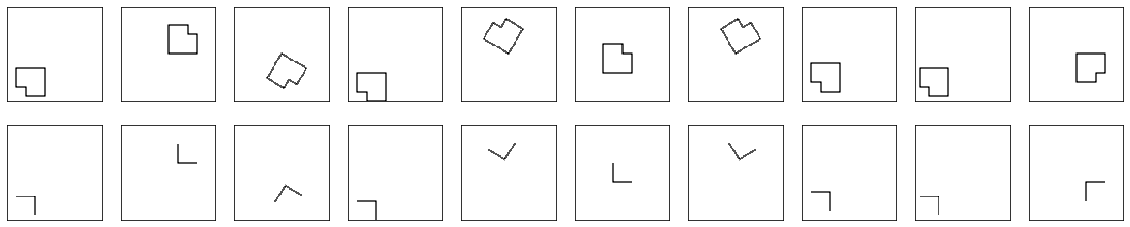

In [10]:
plot_results(profile_pngs_objs[710:720],midcurve_pngs_objs[710:720])

In [0]:
def get_train_test_split(profile_pngs_gray_objs, midcurve_pngs_gray_objs, encoding_dim=imdim, input_dim=imdim):

    # Training
    profile_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in profile_pngs_gray_objs]
    midcurve_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in midcurve_pngs_gray_objs]
    
    profile_pngs_objs = np.array(profile_pngs_flat_objs)
    midcurve_pngs_objs= np.array(midcurve_pngs_flat_objs)
    
    '''
    train_size = int(len(profile_pngs_objs)*0.7)
    x_train = profile_pngs_objs[:train_size]
    y_train = midcurve_pngs_objs[:train_size]
    x_test = profile_pngs_objs[train_size:]
    y_test = midcurve_pngs_objs[train_size:]
    '''
    x_train, x_test, y_train, y_test = train_test_split(profile_pngs_objs, midcurve_pngs_objs, 
                                                        test_size=0.05, random_state=37)
    return x_train, x_test, y_train, y_test

In [12]:
x_train, x_test, y_train, y_test = get_train_test_split(profile_pngs_objs, midcurve_pngs_objs)

print((len(x_train), len(y_train)), (len(x_test), len(y_test)))

(957, 957) (51, 51)


In [0]:
import sys
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
import time
t_start = time.time()
%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, Flatten, Dense
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import optimizers
import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img,save_img

In [0]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [15]:
x_valid = x_test
y_valid = y_test

print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)
print(np.mean(x_train),np.mean(y_train),np.std(x_train),np.std(y_train))
print(np.mean(x_valid),np.mean(y_valid),np.std(x_valid),np.std(y_valid))
print(np.max(x_train),np.max(y_train),np.max(x_valid),np.max(y_valid))
print(np.min(x_train),np.min(y_train),np.min(x_valid),np.min(y_valid))


(957, 101, 101, 1) (957, 101, 101, 1) (51, 101, 101, 1) (51, 101, 101, 1)
2.4964721 1.0767409 18.283064 15.203244
2.7090385 1.1834288 18.9368 16.145807
251.0 255.0 251.0 255.0
0.0 0.0 0.0 0.0


In [0]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [0]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio=0.05):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)

    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv2 = residual_block(uconv1,start_neurons * 1, True)

    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv2)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [18]:
'''
def build_model(input_layer, start_neurons, DropoutRatio = 0.05):
    #input_layer = Input(shape=self.img_shape)

    # encoder
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool2)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    
    # decoder
    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)

    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv2 = residual_block(uconv1,start_neurons * 1, True)

    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation="relu")(uconv2)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

#    return Model(input_layer, output_layer)

'''

'\ndef build_model(input_layer, start_neurons, DropoutRatio = 0.05):\n    #input_layer = Input(shape=self.img_shape)\n\n    # encoder\n    # 101 -> 50\n    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)\n    conv1 = residual_block(conv1,start_neurons * 1)\n    conv1 = residual_block(conv1,start_neurons * 1, True)\n    pool1 = MaxPooling2D((2, 2))(conv1)\n    pool1 = Dropout(DropoutRatio/2)(pool1)\n\n    # 50 -> 25\n    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)\n    conv2 = residual_block(conv2,start_neurons * 2)\n    conv2 = residual_block(conv2,start_neurons * 2, True)\n    pool2 = MaxPooling2D((2, 2))(conv2)\n    pool2 = Dropout(DropoutRatio)(pool2)\n    \n    # Middle\n    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool2)\n    convm = residual_block(convm,start_neurons * 16)\n    convm = residual_block(convm,start_neurons * 16, True)\n    \n    \n    # decoder\n   

In [0]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)


In [0]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss

def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [0]:
#Implementation
#Both finding the optimal range of learning rates and assigning a learning rate schedule can be implemented quite trivially using Keras Callbacks.
#Finding the optimal learning rate range
#We can write a Keras Callback which tracks the loss associated with a learning rate varied linearly over a defined range.
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''

    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
    
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay
        self.batch_since_restart = 0
        self.next_restart = cycle_length
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = cycle_length
        self.mult_factor = mult_factor
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()
            
    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [23]:
x_trn, x_val, y_trn, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=79)
print(x_trn.shape,y_trn.shape,x_val.shape,y_val.shape)
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

(765, 101, 101, 1) (765, 101, 101, 1) (192, 101, 101, 1) (192, 101, 101, 1)
(957, 101, 101, 1) (957, 101, 101, 1) (51, 101, 101, 1) (51, 101, 101, 1)


W0816 21:54:22.755629 140079580039040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 21:54:22.788902 140079580039040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 21:54:22.795344 140079580039040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 21:54:22.838052 140079580039040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0816 21:54:22.838911 1400795800

Train on 765 samples, validate on 192 samples
Epoch 1/5
 - 18s - loss: -1.1614e+01 - my_iou_metric: 0.0000e+00 - val_loss: -6.2848e+00 - val_my_iou_metric: 0.0000e+00
Epoch 2/5
 - 9s - loss: -1.6150e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.6267e+01 - val_my_iou_metric: 0.0000e+00
Epoch 3/5
 - 10s - loss: -1.6300e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.2803e+01 - val_my_iou_metric: 0.0000e+00
Epoch 4/5
 - 15s - loss: -1.6413e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.3322e+01 - val_my_iou_metric: 0.0000e+00

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004000999964773655.
Epoch 5/5
 - 16s - loss: -1.6492e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.6547e+01 - val_my_iou_metric: 0.0000e+00


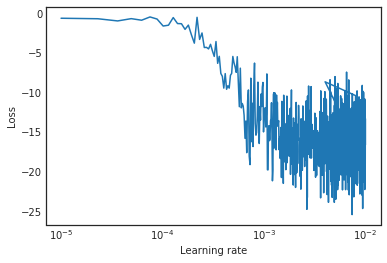

In [24]:
# LR Search -- ResUnet with binary_crossentropy loss
mt1 = time.time()
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16, 0.5)
model = Model(input_layer, output_layer)

reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=3, min_lr=0.00001, verbose=1)

epochs = 5
batch_size = 5
epoch_size = len(x_trn)
lr=0.01
lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-2, 
                    steps_per_epoch=np.ceil(epoch_size/batch_size), 
                    epochs=epochs)

#optimizer = SGD(lr=lr, momentum=0.8, decay=0.001, nesterov=False)
optimizer = optimizers.adam(lr = lr)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[my_iou_metric])

history = model.fit(x_trn, y_trn,
                    validation_data=[x_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[lr_finder,reduce_lr], 
                    verbose=2)
lr_finder.plot_loss()
mt2 = time.time()

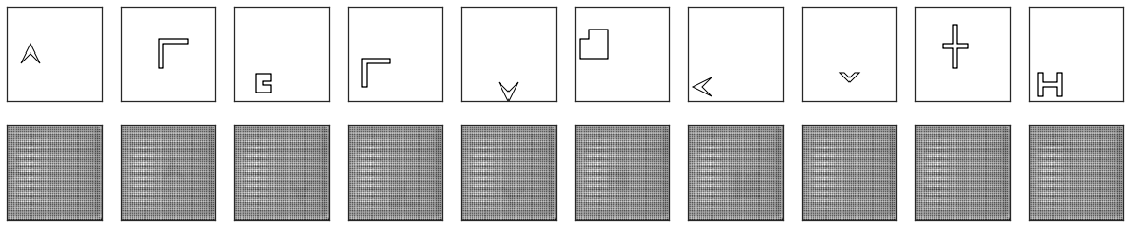

In [25]:
encoded_imgs = model.predict(x_val)
decoded_imgs = model.predict(encoded_imgs)

plot_results(x_val, decoded_imgs)

In [26]:
version = 1.1
basic_name = f'LR_midsurface_v{version}'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

LR_midsurface_v1.1.model
LR_midsurface_v1.1.csv


In [27]:
# Test1-1 -- ResUnet with binary_crossentropy loss
# With cosine annealing learning rate scheduler with periodic restarts

mt1 = time.time()
save_model_name = basic_name + '.model1'
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.25)
model = Model(input_layer, output_layer)

model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=3, min_lr=0.0001, verbose=1)

epochs = 30
batch_size = 5
epoch_size = len(x_trn)
lr=0.01
schedule = SGDRScheduler(min_lr=1e-4,
                        max_lr=1e-2,
                        steps_per_epoch=np.ceil(epoch_size/batch_size),
                        lr_decay=0.9,
                        cycle_length=5,
                        mult_factor=1.5)

#optimizer = SGD(lr=lr, momentum=0.8, decay=0.001, nesterov=False)
optimizer = optimizers.adam(lr = lr)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[my_iou_metric])

history = model.fit(x_trn, y_trn,
                    validation_data=[x_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[schedule,reduce_lr, model_checkpoint], 
                    verbose=2)
mt2 = time.time()
print(f"Test1-1 {epochs,batch_size} runtime = {(mt2-mt1)/60} mins")
print("Evaluation on X_valid:", model.evaluate(x_valid, y_valid))

Train on 765 samples, validate on 192 samples
Epoch 1/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170409). Check your callbacks.
  % delta_t_median)


 - 17s - loss: -1.4801e+01 - my_iou_metric: 0.0000e+00 - val_loss: -3.3054e+00 - val_my_iou_metric: 0.0000e+00

Epoch 00001: my_iou_metric improved from -inf to 0.00000, saving model to LR_midsurface_v1.1.model1
Epoch 2/30
 - 16s - loss: -1.6195e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.3865e+01 - val_my_iou_metric: 0.0000e+00

Epoch 00002: my_iou_metric did not improve from 0.00000
Epoch 3/30
 - 16s - loss: -1.6398e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.6268e+01 - val_my_iou_metric: 0.0000e+00

Epoch 00003: my_iou_metric did not improve from 0.00000
Epoch 4/30
 - 13s - loss: -1.6536e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.6477e+01 - val_my_iou_metric: 0.0000e+00

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005226829671300948.

Epoch 00004: my_iou_metric did not improve from 0.00000
Epoch 5/30
 - 9s - loss: -1.6545e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.6628e+01 - val_my_iou_metric: 0.0000e+00

Epoch 00005: my_iou_metric did not improve from 

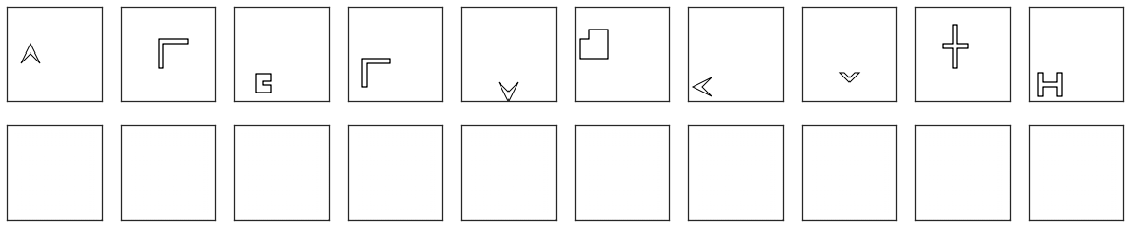

In [28]:
encoded_imgs = model.predict(x_val)
decoded_imgs = model.predict(encoded_imgs)

plot_results(x_val, decoded_imgs)

Text(0.5, 1.0, 'Cosine annealing learning rate scheduler with periodic restarts')

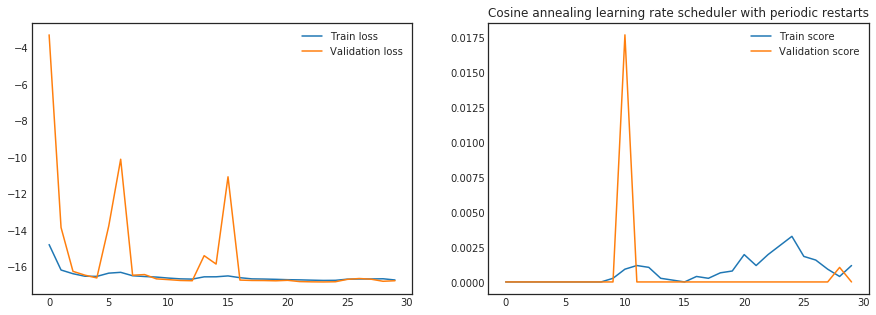

In [29]:
#Test1-1 Performance
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
plt.title('ResUNet: Binary Crossentropy Loss')
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()
plt.title('Cosine annealing learning rate scheduler with periodic restarts')

In [0]:
save_model_name = basic_name + '.model1'


Train on 765 samples, validate on 192 samples
Epoch 1/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.375987). Check your callbacks.
  % delta_t_median)


 - 19s - loss: 0.5593 - my_iou_metric_2: 0.0094 - val_loss: 0.3431 - val_my_iou_metric_2: 0.0141
Epoch 2/30
 - 10s - loss: 0.3129 - my_iou_metric_2: 0.0157 - val_loss: 0.2246 - val_my_iou_metric_2: 0.0078
Epoch 3/30
 - 10s - loss: 0.1733 - my_iou_metric_2: 0.0119 - val_loss: 0.1289 - val_my_iou_metric_2: 0.0078

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005044999998062849.
Epoch 4/30
 - 10s - loss: 0.1016 - my_iou_metric_2: 0.0094 - val_loss: 0.0577 - val_my_iou_metric_2: 0.0125
Epoch 5/30
 - 10s - loss: 0.0574 - my_iou_metric_2: 0.0095 - val_loss: 0.0377 - val_my_iou_metric_2: 0.0161
Epoch 6/30
 - 10s - loss: 0.0445 - my_iou_metric_2: 0.0139 - val_loss: 0.0320 - val_my_iou_metric_2: 0.0464
Epoch 7/30
 - 10s - loss: 0.0364 - my_iou_metric_2: 0.0144 - val_loss: 0.0292 - val_my_iou_metric_2: 0.0599
Epoch 8/30
 - 10s - loss: 0.0338 - my_iou_metric_2: 0.0210 - val_loss: 0.0348 - val_my_iou_metric_2: 0.0099
Epoch 9/30
 - 10s - loss: 0.0421 - my_iou_metric_2: 0.0176 - val_l

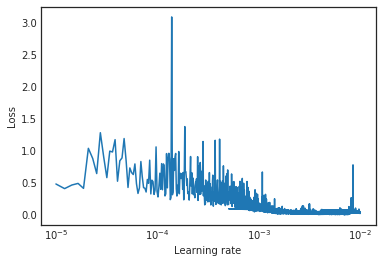

In [31]:
# Test1-2: continue with Lovasz Loss, LR Search
mt1 = time.time()
model = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
input_x = model.layers[0].input
output_layer = model.layers[-1].input
model = Model(input_x, output_layer)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=2, min_lr=0.00001, verbose=1)
epochs = 30
batch_size = 5
epoch_size = len(x_trn)
lr=0.001
lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-2, 
                    steps_per_epoch=np.ceil(epoch_size/batch_size), 
                    epochs=epochs)

c = optimizers.adam(lr = lr)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
history = model.fit(x_trn, y_trn,
                    validation_data=[x_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[lr_finder,reduce_lr], 
                    verbose=2)
lr_finder.plot_loss()
mt2 = time.time()

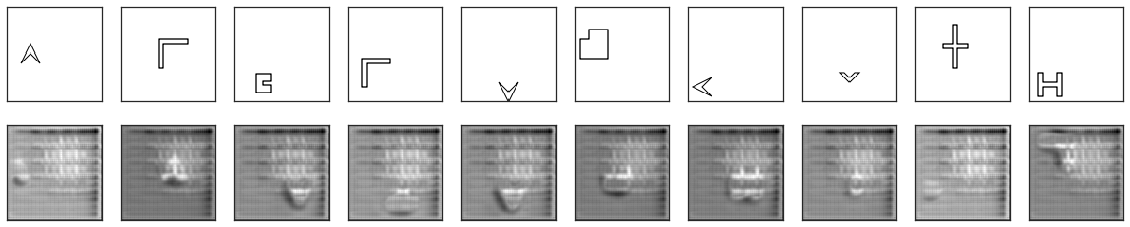

In [32]:
encoded_imgs = model.predict(x_val)
decoded_imgs = model.predict(encoded_imgs)

plot_results(x_val, decoded_imgs)

In [33]:
# Test1-2: continue with Lovasz Loss
mt1 = time.time()
model = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
input_x = model.layers[0].input
output_layer = model.layers[-1].input
model = Model(input_x, output_layer)

save_model_name = basic_name + '.model2'
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=2, min_lr=0.00001, verbose=1)
epochs = 30
batch_size = 5
epoch_size = len(x_trn)
lr=0.001
schedule = SGDRScheduler(min_lr=1e-5,
                        max_lr=1e-3,
                        steps_per_epoch=np.ceil(epoch_size/batch_size),
                        lr_decay=0.9,
                        cycle_length=5,
                        mult_factor=1.5)
c = optimizers.adam(lr = lr)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
history = model.fit(x_trn, y_trn,
                    validation_data=[x_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[schedule,reduce_lr,model_checkpoint], 
                    verbose=2)
mt2 = time.time()
print(f"Test1-2 {epochs,batch_size} runtime = {(mt2-mt1)/60} mins")
print("Evaluation on X_valid:", model.evaluate(x_valid, y_valid))

Train on 765 samples, validate on 192 samples
Epoch 1/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.539270). Check your callbacks.
  % delta_t_median)


 - 23s - loss: 0.3424 - my_iou_metric_2: 0.0124 - val_loss: 0.2249 - val_my_iou_metric_2: 0.0021

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.00208, saving model to LR_midsurface_v1.1.model2
Epoch 2/30
 - 11s - loss: 0.1494 - my_iou_metric_2: 0.0107 - val_loss: 0.1055 - val_my_iou_metric_2: 0.0141

Epoch 00002: val_my_iou_metric_2 improved from 0.00208 to 0.01406, saving model to LR_midsurface_v1.1.model2
Epoch 3/30
 - 11s - loss: 0.1113 - my_iou_metric_2: 0.0110 - val_loss: 0.0934 - val_my_iou_metric_2: 0.0073

Epoch 00003: val_my_iou_metric_2 did not improve from 0.01406
Epoch 4/30
 - 11s - loss: 0.0924 - my_iou_metric_2: 0.0092 - val_loss: 0.0732 - val_my_iou_metric_2: 0.0052

Epoch 00004: ReduceLROnPlateau reducing learning rate to 5.226829307503067e-05.

Epoch 00004: val_my_iou_metric_2 did not improve from 0.01406
Epoch 5/30
 - 18s - loss: 0.0861 - my_iou_metric_2: 0.0114 - val_loss: 0.0684 - val_my_iou_metric_2: 0.0078

Epoch 00005: val_my_iou_metric_2 did not impro

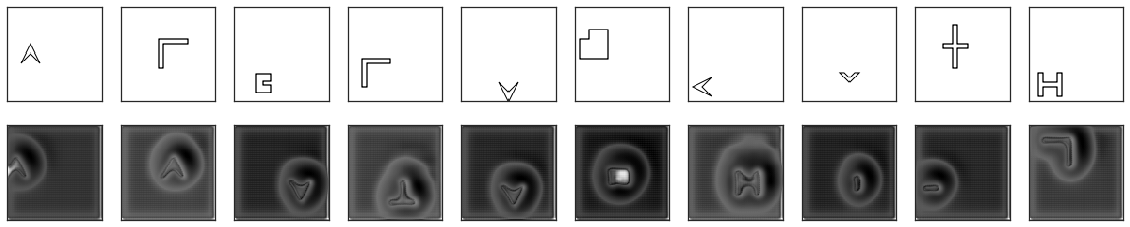

In [34]:
encoded_imgs = model.predict(x_val)
decoded_imgs = model.predict(encoded_imgs)

plot_results(x_val, decoded_imgs)

Text(0.5, 1.0, 'Cosine annealing learning rate scheduler with periodic restarts')

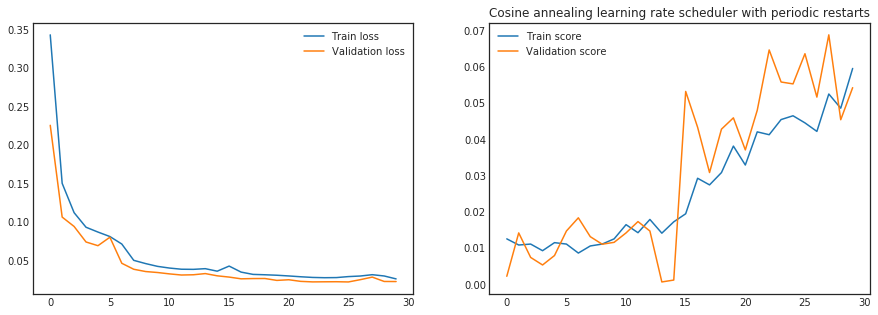

In [35]:
#Test1-2 Performance
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
plt.title('ResUNet: Continue on Lovasz Loss')
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()
plt.title('Cosine annealing learning rate scheduler with periodic restarts')

In [36]:
# Test2-1 -- ResUnet with binary_crossentropy loss
# Without cosine annealing learning rate scheduler with periodic restarts

mt1 = time.time()
save_model_name = basic_name + '.model3'
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.25)
model = Model(input_layer, output_layer)

model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=3, min_lr=0.0001, verbose=1)

epochs = 30
batch_size = 5
epoch_size = len(x_trn)
lr=0.01

optimizer = optimizers.adam(lr = lr)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[my_iou_metric])

history = model.fit(x_trn, y_trn,
                    validation_data=[x_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[reduce_lr, model_checkpoint], 
                    verbose=2)
mt2 = time.time()
print(f"Test2-1 {epochs,batch_size} runtime = {(mt2-mt1)/60} mins")
print("Evaluation on X_valid:", model.evaluate(x_valid, y_valid))

Train on 765 samples, validate on 192 samples
Epoch 1/30
 - 29s - loss: -1.4912e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.3339e+01 - val_my_iou_metric: 0.0000e+00

Epoch 00001: my_iou_metric improved from -inf to 0.00000, saving model to LR_midsurface_v1.1.model3
Epoch 2/30
 - 9s - loss: -1.6070e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.4815e+01 - val_my_iou_metric: 0.0000e+00

Epoch 00002: my_iou_metric did not improve from 0.00000
Epoch 3/30
 - 13s - loss: -1.6224e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.1065e+01 - val_my_iou_metric: 0.0000e+00

Epoch 00003: my_iou_metric did not improve from 0.00000
Epoch 4/30
 - 12s - loss: -1.6285e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.5602e+01 - val_my_iou_metric: 0.0000e+00

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00004: my_iou_metric did not improve from 0.00000
Epoch 5/30
 - 9s - loss: -1.6365e+01 - my_iou_metric: 0.0000e+00 - val_loss: -1.5803e+01 - val_my_iou_metric: 0.000

In [0]:
encoded_imgs = model.predict(x_val)
decoded_imgs = model.predict(encoded_imgs)

plot_results(x_val, decoded_imgs)

Text(0.5, 1.0, 'Without cosine annealing learning rate scheduler with periodic restarts')

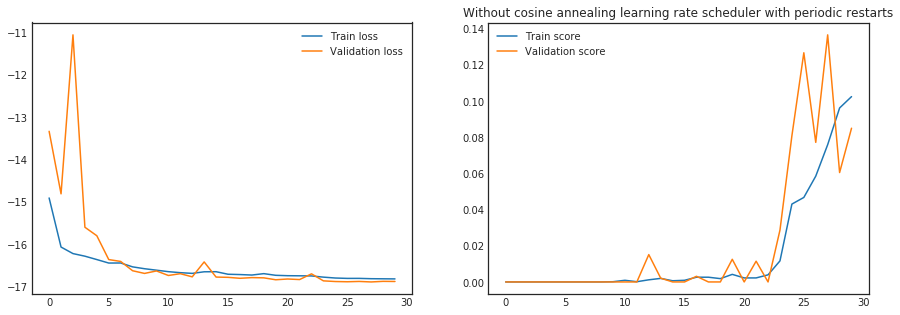

In [38]:
#Test2-1 Performance
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
plt.title('ResUNet: Binary Crossentropy Loss')
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()
plt.title('Without cosine annealing learning rate scheduler with periodic restarts')

In [0]:
# Test2-2: continue with Lovasz Loss
mt1 = time.time()
model = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
input_x = model.layers[0].input
output_layer = model.layers[-1].input
model = Model(input_x, output_layer)

save_model_name = basic_name + '.model2'
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=2, min_lr=0.00001, verbose=1)
epochs = 30
batch_size = 5
epoch_size = len(x_trn)
lr=0.001
c = optimizers.adam(lr = lr)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
history = model.fit(x_trn, y_trn,
                    validation_data=[x_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[reduce_lr,model_checkpoint], 
                    verbose=2)
mt2 = time.time()
print(f"Test2-2 {epochs,batch_size} runtime = {(mt2-mt1)/60} mins")
print("Evaluation on X_valid:", model.evaluate(x_valid, y_valid))

Train on 765 samples, validate on 192 samples
Epoch 1/30
 - 33s - loss: 0.2025 - my_iou_metric_2: 0.2139 - val_loss: 0.0832 - val_my_iou_metric_2: 0.2292

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.22917, saving model to LR_midsurface_v1.1.model2


In [0]:
encoded_imgs = model.predict(x_val)
decoded_imgs = model.predict(encoded_imgs)

plot_results(x_test, decoded_imgs)

In [0]:
#Test2-2 Performance
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
plt.title('ResUNet: Lavasz Loss')
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()
plt.title('Without cosine annealing learning rate scheduler with periodic restarts')